# Experiment1
## Adjust hyper paprameters and get scores on three datasets, output three scores figure

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import Dina
from Dina import McmcHoDina
from Dina import MlDina
import pandas as pd
from utils import r4beta
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import progressbar
from transformer import MyDataSet, Transformer

In [2]:
def load_data(path, ratio):
    full_data = pd.read_csv(path + 'data.txt', header=None, sep='\t').values
    q_matrix = pd.read_csv(path + 'q.txt', header=None, sep='\t').values
    num_samples, num_items, num_skills = full_data.shape[0], full_data.shape[1], q_matrix.shape[1]
    
    train_data = full_data[ : int(num_samples * ratio)]
    train_data = binary_classify(train_data)
    test_data = full_data[int(num_samples * ratio): ]
    test_data = binary_classify(test_data)
    
    return train_data, test_data, q_matrix, num_samples, num_items, num_skills

def binary_classify(data):
    data[data <= 0.5] = 0
    data[data > 0.5] = 1
    return data.astype(np.int64)

def get_scores(true_scores, pred_scores):

    fpr, tpr, thresholds = metrics.roc_curve(true_scores, pred_scores)
    # accuracy, precision, recall, f1
    pred_scores = binary_classify(pred_scores)
    accuracy = accuracy_score(true_scores, pred_scores)
    precision = precision_score(true_scores, pred_scores)
    recall = recall_score(true_scores, pred_scores)
    f1 = f1_score(true_scores, pred_scores)
    
    roc_auc = roc_auc_score(true_scores, pred_scores)

    return accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc

def get_prior_skills(x, y, q_matrix):
    guess = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    slip = r4beta(1, 2, 0, 0.6, (1, x.shape[1]))
    max_iter = 100
    tol = 1e-5
    EmDina = Dina.EmDina(guess, slip, max_iter, tol, q_matrix, x)
    est_s, est_g = EmDina.em()
    dina_est = Dina.MlDina(est_g, est_s, q_matrix, y)
    est_skills = dina_est.get_skills_by_Ml()
    return est_skills

In [3]:
train_data1, test_data1, q_matrix1, num_samples1, num_items1, num_skills1 = load_data('./FrcSub/', 0.8)
train_data2, test_data2, q_matrix2, num_samples2, num_items2, num_skills2 = load_data('./Math1/', 0.8)
train_data3, test_data3, q_matrix3, num_samples3, num_items3, num_skills3 = load_data('./Math2/', 0.8)
batch_size1 = int(num_samples1 / 50)
batch_size2 = int(num_samples2 / 50)
batch_size3 = int(num_samples3 / 50)

In [4]:
num_samples, num_items, num_skills, batch_size = num_samples1, num_items1, num_skills1, batch_size1
x_train, y_train, x_test, y_test, q_matrix = train_data1, train_data1, test_data1, test_data1, q_matrix1

src_len = num_items # enc_input max sequence length
tgt_len = num_items # dec_input(=dec_output) max sequence length

est_skills = get_prior_skills(x_train, y_train, q_matrix)

enc_inputs = torch.LongTensor(x_train)
dec_inputs = torch.LongTensor(est_skills)
dec_outputs = torch.FloatTensor(y_train)

In [5]:
def train(dataset):
    train_data, test_data, q_matrix, num_samples, num_items, num_skills = load_data('./'+ dataset + '/', 0.8)
    x_train, y_train, x_test, y_test = train_data, train_data, test_data, test_data
    batch_size = int(num_samples / 50)
    epoch_size = 100
    src_len = num_items # enc_input max sequence length
    tgt_len = num_items # dec_input(=dec_output) max sequence length

    est_skills_train = get_prior_skills(x_train, y_train, q_matrix)
    enc_inputs_train = torch.LongTensor(x_train)
    dec_inputs_train = torch.LongTensor(est_skills_train)
    dec_outputs_train = torch.FloatTensor(y_train)
    
    est_skills_test = get_prior_skills(x_test, y_test, q_matrix)
    enc_inputs_test = torch.LongTensor(x_test)
    dec_inputs_test = torch.LongTensor(est_skills_test)
    dec_outputs_test = torch.FloatTensor(y_test)
    
    loader = Data.DataLoader(MyDataSet(enc_inputs_train, dec_inputs_train, dec_outputs_train), batch_size, True)
    model = Transformer(num_items, num_skills, d_model=32, d_ff=16, d_k=8, d_v=8, n_layers=3, n_heads=8, batch_size=batch_size)
    loss_func = nn.MSELoss()
    #optimizer = optim.SGD(model.parameters(), lr=1e-3)
    optimizer =optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
    accuracy_his, precision_his, recall_his, f1_his, fpr_his, roc_auc_his = [], [], [], [], [], []
    max_auc = 0
    for epoch in range(epoch_size):

        for enc_inputs_batch, dec_inputs_batch, dec_outputs_batch in loader:

            outputs_batch, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_batch, dec_inputs_batch)

            #print(outputs.shape, dec_outputs.shape) # outputs[400, 20]: 400 = 50(batch_size) * 8(tgt_len), 20(tgt_vocab_size) # dec_outputs[50, 8]: [batch_size, tgt_len]
            #break
            loss = loss_func(outputs_batch, dec_outputs_batch)
            #if (epoch + 1) == 100:
            #    loss_his.append(loss.data.item())
            #print(loss.dtype)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
            
            
        # get RMSE on test dataset:
        with torch.no_grad():
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs_test, dec_inputs_test)
            predict = outputs.detach().numpy()
            pred = predict.reshape(-1)
            true = y_test.reshape(-1)
            true = binary_classify(true)
        accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = get_scores(true, pred)
        if roc_auc > max_auc:
            max_auc = roc_auc
            torch.save(model.state_dict(), './Results/Transformer_state_dict_Experiment1_' + dataset + '.pt')

        accuracy_his.append(accuracy)
        precision_his.append(precision)
        recall_his.append(recall)
        f1_his.append(f1)
        roc_auc_his.append(roc_auc)
    
    print("Accuracy: {:4.6f} | Precision: {:4.6f} | Recall: {:4.6f} | F1: {:4.6f} | AUC: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))
    
    #torch.save(model.state_dict(), './Results/Transformer_state_dict_Experiment1' + dataset + '.pt')
    
    return accuracy_his, precision_his, recall_his, f1_his, roc_auc_his

In [6]:
print("> Training on Frcsub Dataset with epoch 100:")
accuracy_his1, precision_his1, recall_his1, f1_his1, roc_auc_his1 = train('FrcSub')
print("> Training on Math1 Dataset with epoch 100:")
accuracy_his2, precision_his2, recall_his2, f1_his2, roc_auc_his2 = train('Math1')
print("> Training on Math2 Dataset with epoch 100:")
accuracy_his3, precision_his3, recall_his3, f1_his3, roc_auc_his3 = train('Math2')

> Training on Frcsub Dataset with epoch 100:
Epoch: 0010 loss = 0.076337
Epoch: 0020 loss = 0.069208
Epoch: 0030 loss = 0.063493
Epoch: 0040 loss = 0.084944
Epoch: 0050 loss = 0.075159
Epoch: 0060 loss = 0.083819
Epoch: 0070 loss = 0.123391
Epoch: 0080 loss = 0.050250
Epoch: 0090 loss = 0.090217
Epoch: 0100 loss = 0.067357
Accuracy: 0.894444 | Precision: 0.866211 | Recall: 0.906953 | F1: 0.886114 | AUC: 0.895524
> Training on Math1 Dataset with epoch 100:
Epoch: 0010 loss = 0.118846
Epoch: 0020 loss = 0.098411
Epoch: 0030 loss = 0.105157
Epoch: 0040 loss = 0.104455
Epoch: 0050 loss = 0.110889
Epoch: 0060 loss = 0.125383
Epoch: 0070 loss = 0.121340
Epoch: 0080 loss = 0.117514
Epoch: 0090 loss = 0.118529
Epoch: 0100 loss = 0.110894
Accuracy: 0.805938 | Precision: 0.773463 | Recall: 0.811015 | F1: 0.791794 | AUC: 0.806358
> Training on Math2 Dataset with epoch 100:
Epoch: 0010 loss = 0.092227
Epoch: 0020 loss = 0.092781
Epoch: 0030 loss = 0.120087
Epoch: 0040 loss = 0.112155
Epoch: 0050 l

In [7]:
def draw_scores(dataset, accuracy_his, precision_his, recall_his, f1_his, roc_auc_his):
    xrange = np.arange(0,len(accuracy_his))
    plt.grid(b=True, color='gray', linestyle='--', linewidth=1, alpha=0.3) 
    plt.xlim(0, 50)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Epoch')
    plt.ylabel('Scores')
    plt.title(dataset)
    #plt.plot(fpr_list[0], tpr_list[0], color='darkorange', lw=2, label='Frbsub (area = %0.3f)' % roc_auc_list[0])
    plt.plot(xrange, accuracy_his, color='r', linestyle='-', label='Rmse')
    plt.plot(xrange, precision_his, color='g', linestyle='--', label='Precision')
    plt.plot(xrange, recall_his, color='orange', linestyle='-.', label='Recall')
    plt.plot(xrange, f1_his, color='b', linestyle=':', label='F1')
    plt.plot(xrange, roc_auc_his, linestyle='-', color='purple', label='AUC')
    plt.legend(loc="lower right")
    plt.savefig('./Results/scores_' + dataset + '.png')

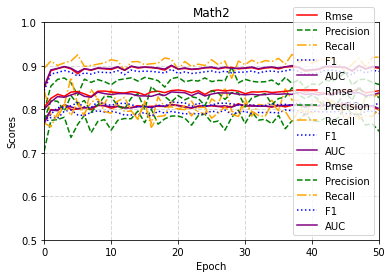

In [8]:
draw_scores('FrcSub', accuracy_his1, precision_his1, recall_his1, f1_his1, roc_auc_his1)
draw_scores('Math1', accuracy_his2, precision_his2, recall_his2, f1_his2, roc_auc_his2)
draw_scores('Math2', accuracy_his3, precision_his3, recall_his3, f1_his3, roc_auc_his3)

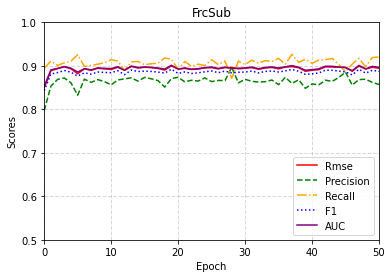

In [9]:
draw_scores('FrcSub', accuracy_his1, precision_his1, recall_his1, f1_his1, roc_auc_his1)

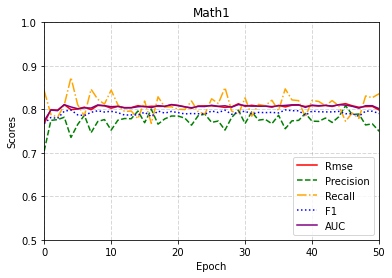

In [10]:
draw_scores('Math1', accuracy_his2, precision_his2, recall_his2, f1_his2, roc_auc_his2)

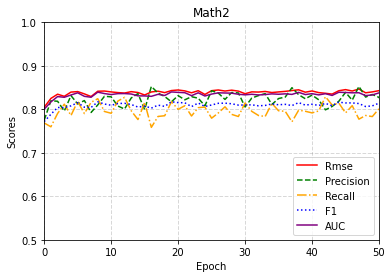

In [11]:
draw_scores('Math2', accuracy_his3, precision_his3, recall_his3, f1_his3, roc_auc_his3)

In [12]:
accuracy_his1, accuracy_his2, accuracy_his3 = np.array(accuracy_his1), np.array(accuracy_his2), np.array(accuracy_his3)
precision_his1, precision_his2, precision_his3 = np.array(precision_his1), np.array(precision_his2), np.array(precision_his3)
recall_his1, recall_his2, recall_his3 = np.array(recall_his1), np.array(recall_his2), np.array(recall_his3)
f1_his1, f1_his2, f1_his3 = np.array(f1_his1), np.array(f1_his2), np.array(f1_his3)
roc_auc_his1, roc_auc_his2, roc_auc_his3 = np.array(roc_auc_his1), np.array(roc_auc_his2), np.array(roc_auc_his3)

In [13]:
accurcy_his_Experiment1 = np.array([accuracy_his1, accuracy_his2, accuracy_his3])
precision_his_Experiment1 = np.array([precision_his1, precision_his2, precision_his3])
recall_his_Experiment1 = np.array([recall_his1, recall_his2, recall_his3])
f1_his_Experiment1 = np.array([f1_his1, f1_his2, f1_his3])
roc_auc_his_Experiment1 = np.array([roc_auc_his1, roc_auc_his2, roc_auc_his3])
np.save('./Results/data/accurcy_his_Experiment1.npy', accurcy_his_Experiment1)
np.save('./Results/data/precision_his_Experiment1.npy', precision_his_Experiment1)
np.save('./Results/data/recall_his_Experiment1.npy', recall_his_Experiment1)
np.save('./Results/data/f1_his_Experiment1.npy', f1_his_Experiment1)
np.save('./Results/data/roc_auc_his_Experiment1.npy', roc_auc_his_Experiment1)

In [14]:
roc_auc_his_ = np.load('./Results/data/roc_auc_his_Experiment1.npy')
print(roc_auc_his_.shape)

(3, 100)
